#### 군집 분석

<span style="font-size:16px"> - 참고자료 <br> https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap  </span>

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
font_fname = font_fname = "c:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_fname, size=18).get_name()
matplotlib.rc('font',family= fontprop)
matplotlib.rc('axes',unicode_minus=False)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
################
from sklearn.cluster import KMeans 
from yellowbrick.cluster import KElbowVisualizer
################
from sklearn.cluster import DBSCAN
from itertools import product
################
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

#### 데이터 불러오기

In [43]:
df = pd.read_csv("C:/Users/osoomin/Desktop/Tel/tele_customer_final.csv")
df['StDate']=df['StartDate'].apply(lambda x:int(x[0:4]))
df['StDate'].value_counts()

2020    1617
2015    1361
2019     955
2016     820
2018     814
2017     747
2021     549
Name: StDate, dtype: int64

In [44]:
df = df[df['StDate']==2015]
data_list = ["CustomerId", "ChurnLabel", "Monthly_charge", "ChurnScore", "AvgDownloadGB", 
             "AvgRoamCharge", "CustomerLTV","Age"] #"noReferrals",
df = df[data_list]
# 전체 고객/이탈 고객/유지 고객데이터 정의
df1=df.copy()
df = df.iloc[:,2:]
df

,Monthly_charge,ChurnScore,AvgDownloadGB,AvgRoamCharge,CustomerLTV,Age
6,129452.0,26,14,11300,5011,67
7,99408.0,49,7,14690,4604,52
9,106314.0,25,14,32210,5509,43
11,136687.0,52,59,18080,6252,25
13,118873.0,53,16,2600,5513,32
...,...,...,...,...,...,...
6845,81376.0,40,59,43390,5082,20
6848,22634.0,61,0,55140,5154,56
6851,115782.0,52,24,25310,4590,31
6861,80108.0,59,58,2370,4792,21


In [45]:
# Range 조절 ## "noReferrals",
data_list = ["Monthly_charge", "ChurnScore", "AvgDownloadGB","AvgRoamCharge", "CustomerLTV","Age"]
scaler = RobustScaler()
for i in data_list:
    df[i] = scaler.fit_transform(df[[i]])

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df)
df_pca = pd.DataFrame(data=pca_transformed,columns=['pc1','pc2'])
df_pca

,pc1,pc2
0,-0.256075,0.660088
1,-0.556263,0.131798
2,-0.146986,0.093075
3,1.960644,-0.026187
4,0.132003,-0.155151
...,...,...
1356,1.667251,-0.685734
1357,-1.372342,-0.126020
1358,0.422684,-0.074388
1359,1.622932,-1.012090


### 2015년 군집화

- k-means

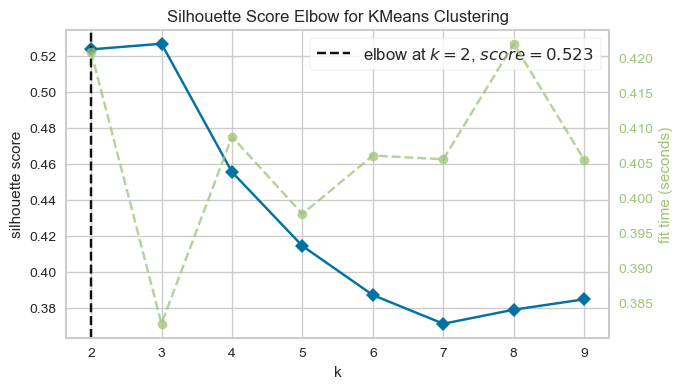

In [5]:
plt.figure(figsize=(7,4))
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')
visualizer.fit(df_pca)
visualizer.show()
plt.show()

In [46]:
kmeans = KMeans(init='k-means++',n_clusters=3)
kmeans.fit(df_pca)

df_pca['kmean_labels'] = kmeans.predict(df_pca)
df_pca.reset_index()
df_pca

,pc1,pc2,kmean_labels
0,-0.256075,0.660088,0
1,-0.556263,0.131798,0
2,-0.146986,0.093075,0
3,1.960644,-0.026187,1
4,0.132003,-0.155151,0
...,...,...,...
1356,1.667251,-0.685734,1
1357,-1.372342,-0.126020,2
1358,0.422684,-0.074388,0
1359,1.622932,-1.012090,1


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

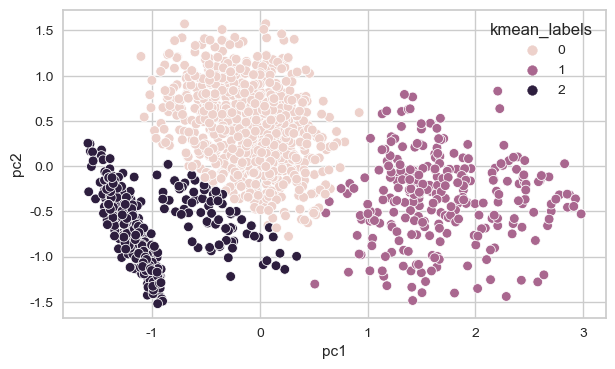

In [47]:
plt.figure(figsize=(7,4))
sns.scatterplot(x='pc1', y='pc2', hue='kmean_labels', data=df_pca)

In [48]:
df_pca['kmean_labels'].value_counts()

0    748
2    354
1    259
Name: kmean_labels, dtype: int64

- DBSCAN

In [8]:
## eps, min_value 최적값 찾기

eps_values = np.arange(0.1,0.6,0.1)
min_samples = np.arange(3,11) 
DBSCAN_params = list(product(eps_values, min_samples))

In [9]:
df_pca_db = df_pca.iloc[:,:2]
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_pca_db)
    if len(list(set(DBS_clustering.labels_))) == 1:
        if list(set(DBS_clustering.labels_)) == [0]:
            no_of_clusters.append(1)
            sil_score.append(0)
            continue
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(df_pca_db, DBS_clustering.labels_))

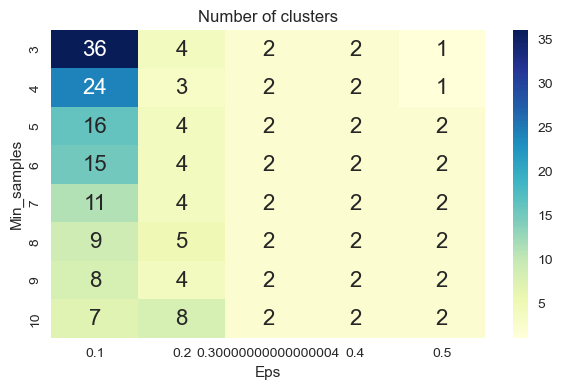

In [10]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp,values='No_of_clusters',index='Min_samples',columns='Eps')

fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(pivot_1,annot=True,annot_kws={"size": 16},cmap="YlGnBu",ax=ax)
ax.set_title('Number of clusters')
plt.show()

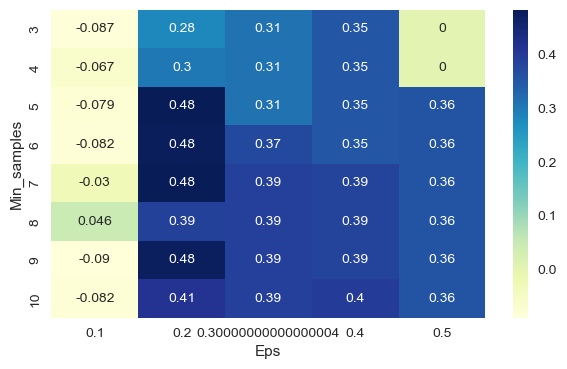

In [11]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [49]:
DBS_clustering = DBSCAN(eps=0.2, min_samples=9).fit(df_pca_db)
df_pca.loc[:,'DBSCAN_Cluster'] = DBS_clustering.labels_
df_pca.reset_index()
df_pca['DBSCAN_Cluster'].value_counts()

 0    815
 2    278
 1    218
-1     50
Name: DBSCAN_Cluster, dtype: int64

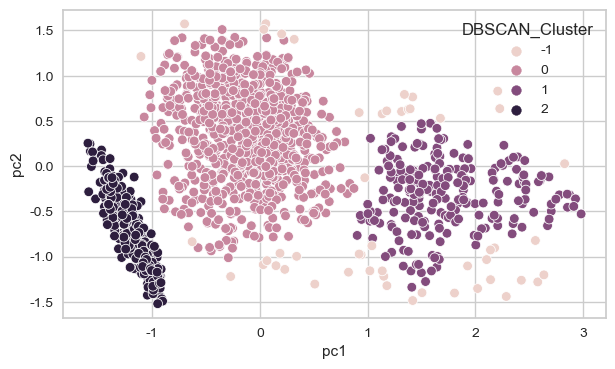

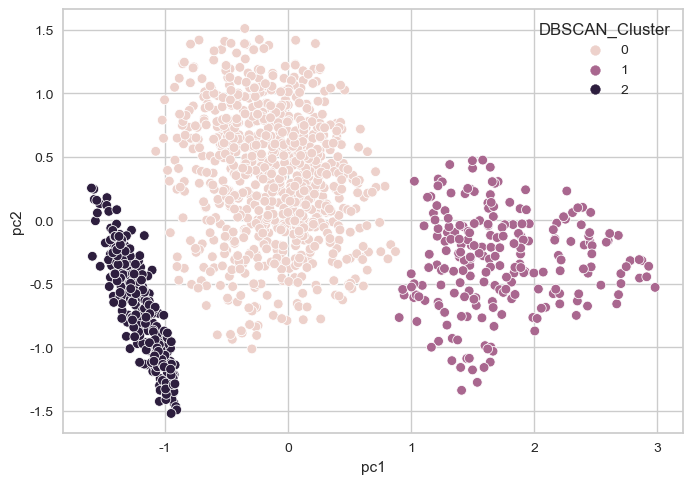

In [50]:
plt.figure(figsize=(7,4))
df_pca_nooutlier = df_pca[df_pca['DBSCAN_Cluster']!=-1]
sns.scatterplot(x='pc1', y='pc2', hue='DBSCAN_Cluster', data=df_pca)
plt.show()
sns.scatterplot(x='pc1', y='pc2', hue='DBSCAN_Cluster', data=df_pca_nooutlier)
plt.show()

- 해석

In [51]:
df_all = df1.copy()

df_all['Monthly_charge_sc'] = df['Monthly_charge']
df_all['ChurnScore_sc'] = df['ChurnScore']
df_all['AvgDownloadGB_sc'] = df['AvgDownloadGB']
df_all['AvgRoamCharge_sc'] = df['AvgRoamCharge']
df_all['CustomerLTV_sc'] = df['CustomerLTV']
df_all['Age_sc'] = df['Age']

df_all

,CustomerId,ChurnLabel,Monthly_charge,ChurnScore,AvgDownloadGB,AvgRoamCharge,CustomerLTV,Age,Monthly_charge_sc,ChurnScore_sc,AvgDownloadGB_sc,AvgRoamCharge_sc,CustomerLTV_sc,Age_sc
6,C-10007,No,129452.0,26,14,11300,5011,67,0.520975,-0.81250,-0.173913,-0.469436,-0.1488,0.777778
7,C-10008,No,99408.0,49,7,14690,4604,52,0.007604,-0.09375,-0.478261,-0.354948,-0.4744,0.222222
9,C-10010,No,106314.0,25,14,32210,5509,43,0.125609,-0.84375,-0.173913,0.236744,0.2496,-0.111111
11,C-10012,No,136687.0,52,59,18080,6252,25,0.644601,0.00000,1.782609,-0.240459,0.8440,-0.777778
13,C-10014,No,118873.0,53,16,2600,5513,32,0.340208,0.03125,-0.086957,-0.763256,0.2528,-0.518519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845,C-17026,No,81376.0,40,59,43390,5082,20,-0.300514,-0.37500,1.782609,0.614319,-0.0920,-0.962963
6848,C-17029,No,22634.0,61,0,55140,5154,56,-1.304256,0.28125,-0.782609,1.011145,-0.0344,0.370370
6851,C-17032,No,115782.0,52,24,25310,4590,31,0.287391,0.00000,0.260870,0.003715,-0.4856,-0.555556
6861,C-17042,No,80108.0,59,58,2370,4792,21,-0.322181,0.21875,1.739130,-0.771023,-0.3240,-0.925926


In [52]:
df_all = df_all.reset_index()
df_all = df_all.drop(['index'],axis=1)

df_all['pc1'] = df_pca['pc1']
df_all['pc2'] = df_pca['pc2']
df_all['kmean_labels']=df_pca['kmean_labels']
df_all['DBSCAN_Cluster']=df_pca['DBSCAN_Cluster']
df_all

,CustomerId,ChurnLabel,Monthly_charge,ChurnScore,AvgDownloadGB,AvgRoamCharge,CustomerLTV,Age,Monthly_charge_sc,ChurnScore_sc,AvgDownloadGB_sc,AvgRoamCharge_sc,CustomerLTV_sc,Age_sc,pc1,pc2,kmean_labels,DBSCAN_Cluster
0,C-10007,No,129452.0,26,14,11300,5011,67,0.520975,-0.81250,-0.173913,-0.469436,-0.1488,0.777778,-0.256075,0.660088,0,0
1,C-10008,No,99408.0,49,7,14690,4604,52,0.007604,-0.09375,-0.478261,-0.354948,-0.4744,0.222222,-0.556263,0.131798,0,0
2,C-10010,No,106314.0,25,14,32210,5509,43,0.125609,-0.84375,-0.173913,0.236744,0.2496,-0.111111,-0.146986,0.093075,0,0
3,C-10012,No,136687.0,52,59,18080,6252,25,0.644601,0.00000,1.782609,-0.240459,0.8440,-0.777778,1.960644,-0.026187,1,1
4,C-10014,No,118873.0,53,16,2600,5513,32,0.340208,0.03125,-0.086957,-0.763256,0.2528,-0.518519,0.132003,-0.155151,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,C-17026,No,81376.0,40,59,43390,5082,20,-0.300514,-0.37500,1.782609,0.614319,-0.0920,-0.962963,1.667251,-0.685734,1,1
1357,C-17029,No,22634.0,61,0,55140,5154,56,-1.304256,0.28125,-0.782609,1.011145,-0.0344,0.370370,-1.372342,-0.126020,2,2
1358,C-17032,No,115782.0,52,24,25310,4590,31,0.287391,0.00000,0.260870,0.003715,-0.4856,-0.555556,0.422684,-0.074388,0,0
1359,C-17042,No,80108.0,59,58,2370,4792,21,-0.322181,0.21875,1.739130,-0.771023,-0.3240,-0.925926,1.622932,-1.012090,1,1


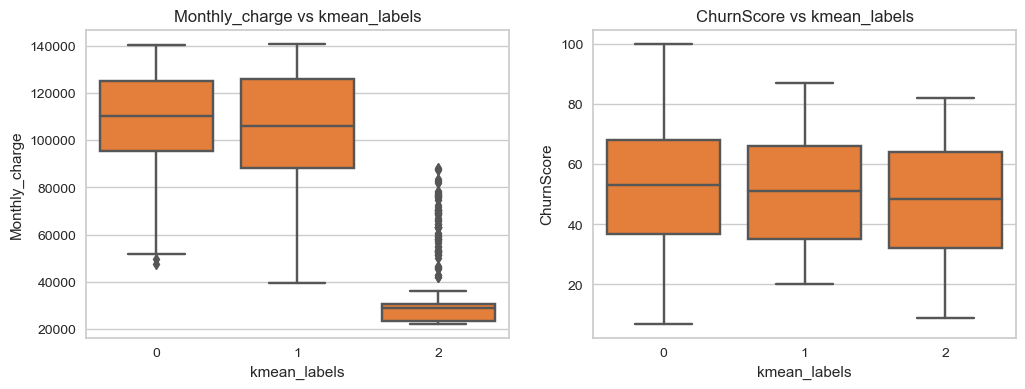

None


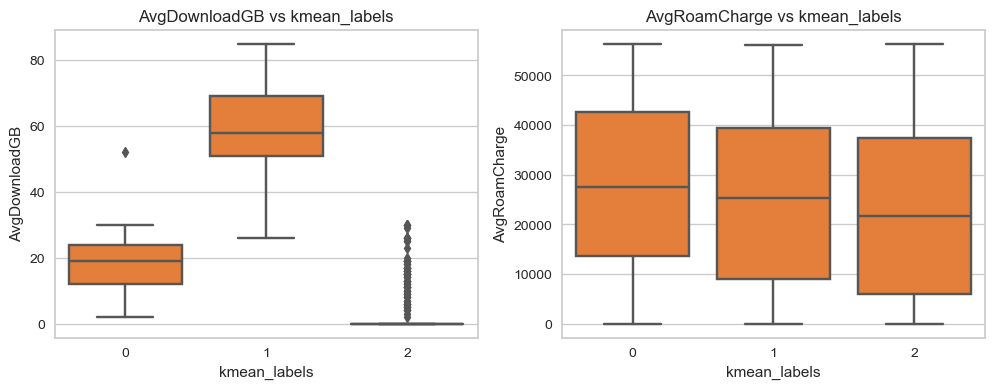

None


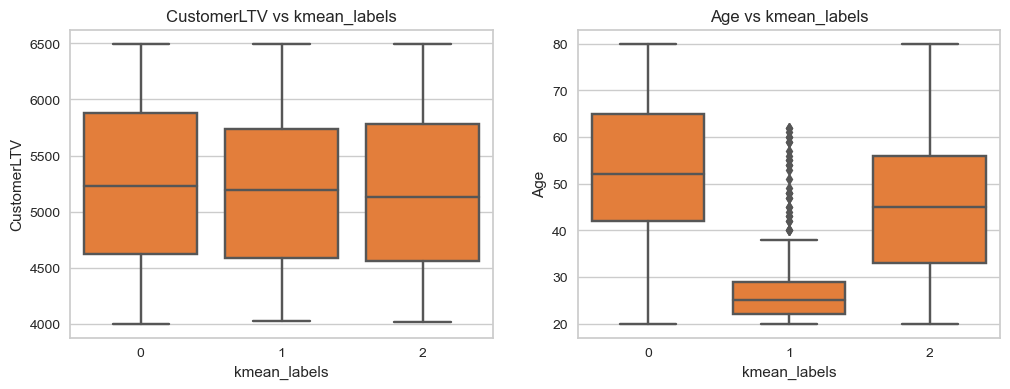

None


In [53]:
## df_all
def box(y1,y2):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

    plt.subplot(1,2,1)
    sns.boxplot(x = 'kmean_labels', y = y1, data  = df_all, color = '#FF781F');
    plt.title(y1+' vs kmean_labels')

    plt.subplot(1,2,2)
    sns.boxplot(x = 'kmean_labels', y = y2, data  = df_all, color = '#FF781F');
    plt.title(y2+' vs kmean_labels')
    plt.show()

print(box('Monthly_charge','ChurnScore'))
print(box('AvgDownloadGB','AvgRoamCharge'))
print(box('CustomerLTV','Age'))

- 0군집 : 월요금은 많이 내는데에 비해, 다운로드 용량은 많다.
- 1군집 : 20-30대 고객층이 많음.
- 2군집 : 월요금을 적게 내고, 다운로드 용량도 적다. 

- 공통점 : 모든 군집의 이탈 가능 점수, 로밍금액, 고객생애가치가 비슷함.

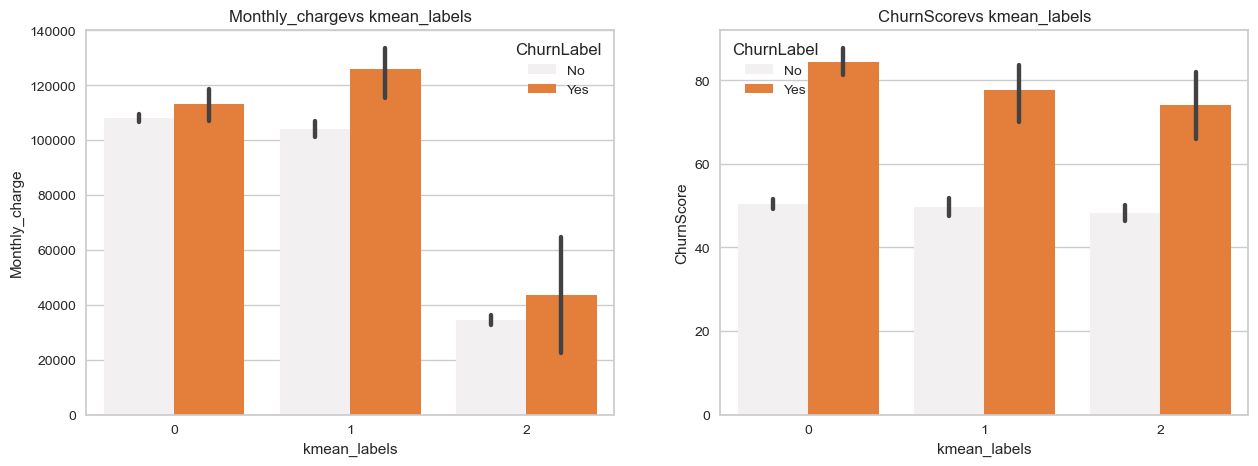

None


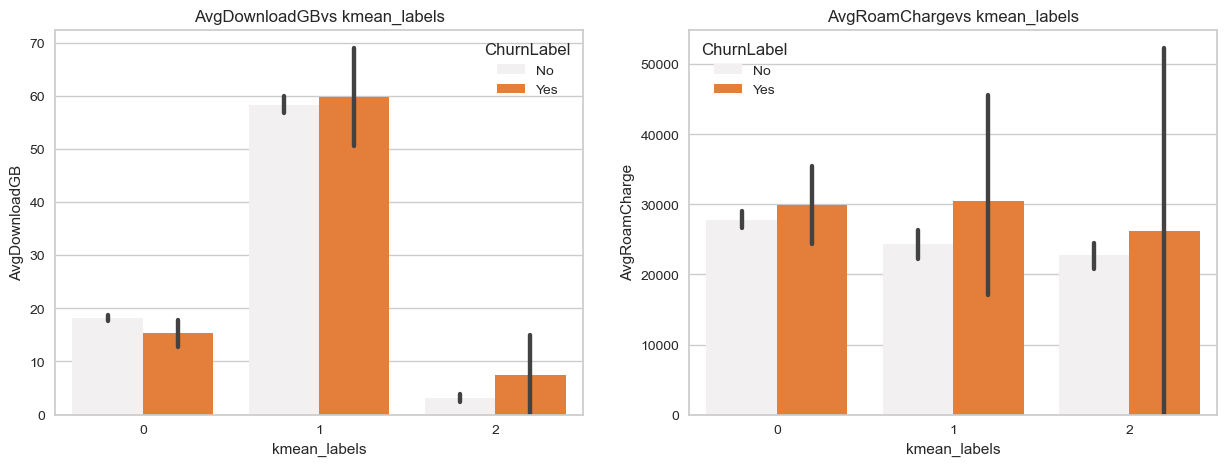

None


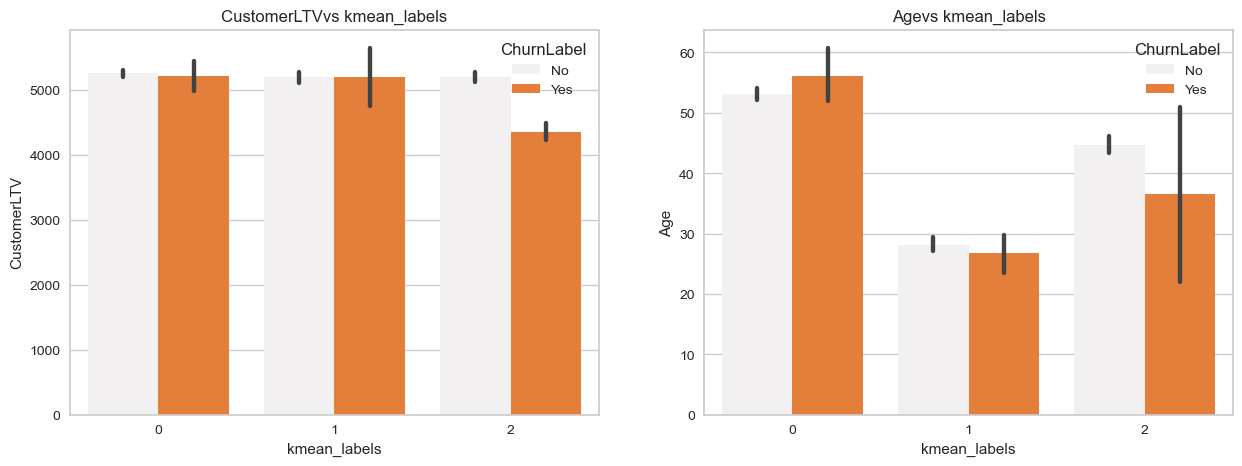

None


In [65]:
def bar(y1, y2):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    plt.subplot(1,2,1)
    sns.barplot(x = 'kmean_labels', y = y1, hue='ChurnLabel',data =df_all, color ='#FF781F');
    plt.title(y1+'vs kmean_labels')
    plt.subplot(1,2,2)
    sns.barplot(x = 'kmean_labels', y = y2, hue='ChurnLabel',data =df_all, color ='#FF781F');
    plt.title(y2+'vs kmean_labels')
    plt.show()

print(bar('Monthly_charge','ChurnScore'))
print(bar('AvgDownloadGB','AvgRoamCharge'))
print(bar('CustomerLTV','Age'))

In [66]:
outliers = df_all[df_all['DBSCAN_Cluster']==-1]
df_all_nooutlier = df_all[df_all['DBSCAN_Cluster']!=-1]

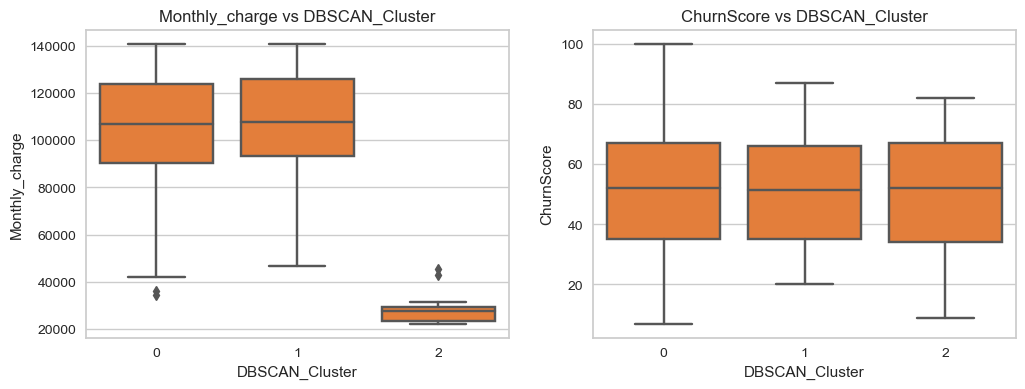

None


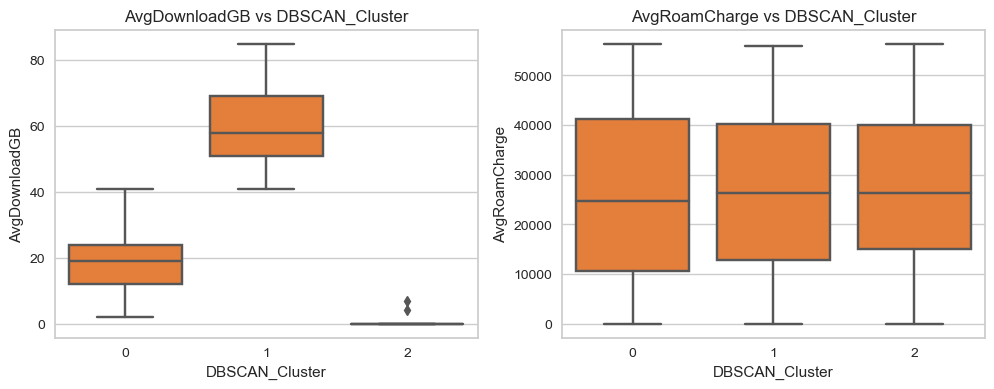

None


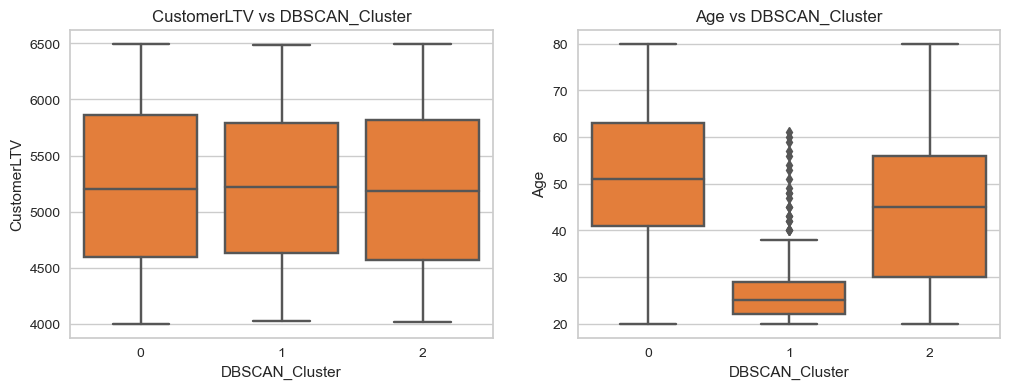

None


In [68]:
## df_all
def box1(y1,y2):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

    plt.subplot(1,2,1)
    sns.boxplot(x = 'DBSCAN_Cluster', y = y1, data  = df_all_nooutlier, color = '#FF781F');
    plt.title(y1+' vs DBSCAN_Cluster')

    plt.subplot(1,2,2)
    sns.boxplot(x = 'DBSCAN_Cluster', y = y2, data  = df_all_nooutlier, color = '#FF781F');
    plt.title(y2+' vs DBSCAN_Cluster')
    plt.show()

print(box1('Monthly_charge','ChurnScore'))
print(box1('AvgDownloadGB','AvgRoamCharge'))
print(box1('CustomerLTV','Age'))

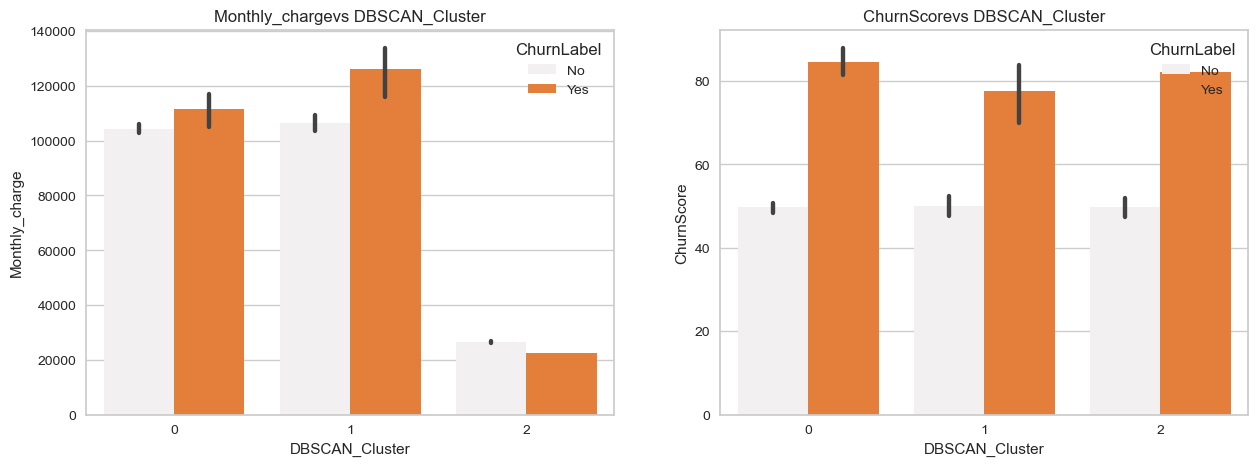

None


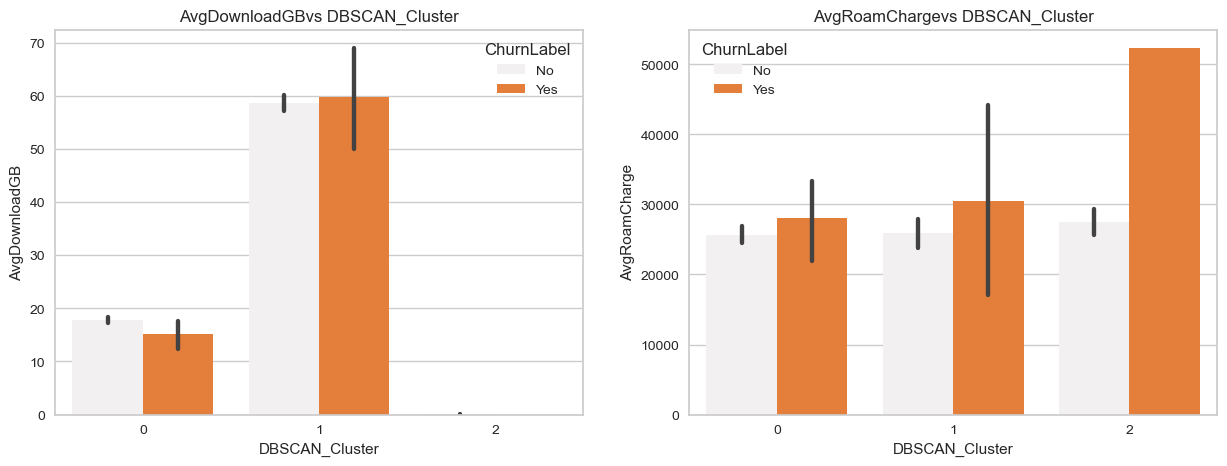

None


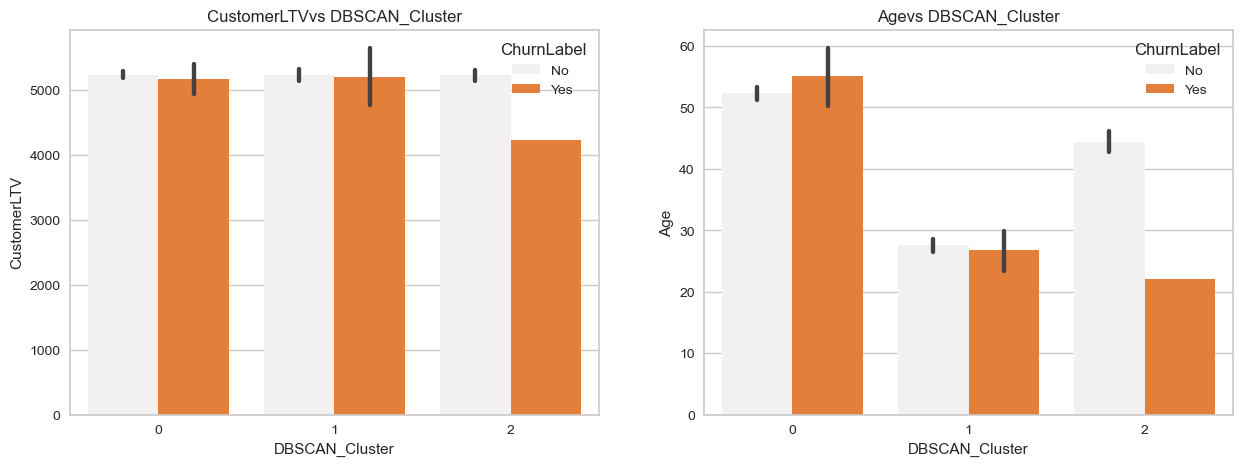

None


In [75]:
# def dbscan_scatt(x1,x2):
#     fig2, (axes) = plt.subplots(1,2,figsize=(12,5))
#     sns.scatterplot(x=x1, y='ChurnScore',data=df_all_nooutlier,
#                     hue='DBSCAN_Cluster', ax=axes[0], palette='Set1', legend='full', s=25)
#     sns.scatterplot(x=x2, y='ChurnScore',data=df_all_nooutlier,
#                     hue='DBSCAN_Cluster', palette='Set1', ax=axes[1], legend='full', s=25)
#     plt.show()

# # dbscan_scatt('Monthly_charge','AvgDownloadGB')

# print(dbscan_scatt('Monthly_charge','ChurnScore'))
# print(dbscan_scatt('AvgDownloadGB','AvgRoamCharge'))
# print(dbscan_scatt('CustomerLTV','Age'))

def bar1(y1, y2):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    plt.subplot(1,2,1)
    sns.barplot(x = 'DBSCAN_Cluster', y = y1, hue='ChurnLabel',data =df_all_nooutlier, color ='#FF781F');
    plt.title(y1+'vs DBSCAN_Cluster')
    plt.subplot(1,2,2)
    sns.barplot(x = 'DBSCAN_Cluster', y = y2, hue='ChurnLabel',data =df_all_nooutlier, color ='#FF781F');
    plt.title(y2+'vs DBSCAN_Cluster')
    plt.show()

print(bar1('Monthly_charge','ChurnScore'))
print(bar1('AvgDownloadGB','AvgRoamCharge'))
print(bar1('CustomerLTV','Age'))